In [1]:
import jax
import jax.numpy as jnp
import numpy as np
from typing import NamedTuple


class RCMDP(NamedTuple):
    S_set: jnp.array  # state space
    A_set: jnp.array  # action space
    discount: float  # discount
    costs: jnp.array  # cost functions
    threshes: jnp.array  # constraint thresholds
    U: jnp.array  # uncertainty set
    init_dist: jnp.array  # initial distribution

    @property
    def S(self) -> int:  # state space size
        return len(self.S_set)

    @property
    def A(self) -> int:  # action space size
        return len(self.A_set)


S, A = 4, 2  # state and action space sizes
N = 1  # number of constraints
USIZE = 2  # size of uncertainty set
DISCOUNT = 0.5 

In [2]:
import chex
from functools import partial


@jax.jit
def projection_to_simplex(y):
    """project y to a probability simplex
    see：https://arxiv.org/pdf/1309.1541
    Args:
        y (jnp.ndarray): (A)-vector

    Returns:
        x (jnp.ndarray): (A)-vector
    """
    D = len(y)
    u = jnp.sort(y)[::-1]
    u_sum = jnp.cumsum(u)
    rho_pos_flag = (u + (1 - u_sum) / (jnp.arange(D) + 1)) > 0
    rho = jnp.argmax(jnp.cumsum(rho_pos_flag))
    lam = (1 - u_sum[rho]) / (rho + 1)
    x = jnp.maximum(y + lam, 0)
    return x


proj_to_Pi = jax.vmap(projection_to_simplex)

In [3]:
import jax
import jax.numpy as jnp
import numpy as np
from functools import partial
import chex


@jax.jit
def compute_policy_matrix(policy: jnp.ndarray):
    """
    Args:
        policy (jnp.ndarray): (SxA) array

    Returns:
        policy_matrix (jnp.ndarray): (SxSA) array
    """
    S, A = policy.shape
    PI = policy.reshape(1, S, A)
    PI = jnp.tile(PI, (S, 1, 1))
    eyes = jnp.eye(S).reshape(S, S, 1)
    PI = (eyes * PI).reshape(S, S*A)
    return PI


@partial(jax.vmap, in_axes=(None, None, 0, None), out_axes=0)
@partial(jax.vmap, in_axes=(None, None, None, 0), out_axes=0)
def compute_policy_Q(discount: float, policy: jnp.ndarray, cost: jnp.ndarray, P: jnp.ndarray):
    """ Do policy evaluation with cost and transition kernel
    Args:
        discount (float): discount factor
        policy (jnp.ndarray): (SxA) array
        cost (jnp.ndarray): cost function. (SxA) array
        P (jnp.ndarray): transition kernel. (SxAxS) array

    Returns:
        Q (jnp.ndarray): (SxA) array
    """
    S, A = policy.shape

    Pi = compute_policy_matrix(policy)
    PPi = P.reshape(S*A, S) @ Pi
    Q = jnp.linalg.inv(jnp.eye(S*A) - discount * PPi) @ cost.reshape(S*A)
    return Q.reshape(S, A)


@partial(jax.vmap, in_axes=(None, None, None, 0), out_axes=0)
def compute_policy_visit_s(discount: float, policy: jnp.ndarray, init_dist: jnp.ndarray, P: jnp.ndarray):
    """ Compute (unnormalized) occupancy measure of a policy
    Args:
        discount (float): discount factor
        policy (jnp.ndarray): (SxA) array
        init_dist: initial distribution
        P (jnp.ndarray): (SxAxS) array

    Returns:
        d_pi (jnp.ndarray): (S) array
    """
    Pi = compute_policy_matrix(policy)
    PiP = Pi @ P.reshape(S*A, S) 
    d_pi = init_dist @ jnp.linalg.inv(jnp.eye(S) - discount * PiP)
    return d_pi


In [4]:
from typing import NamedTuple, Optional
from jax.random import PRNGKey


def create_rcmdp():
    S_set = jnp.arange(S)
    A_set = jnp.arange(A)
    const = jnp.zeros(N)  # dummy

    # randomly create cost function
    costs = np.ones((N+1, S, A))
    costs[0, 0, 0] = 1
    costs[0, 0, 1] = 0
    costs[0, 1, 0] = 0
    costs[0, 1, 1] = 0
    costs[0, 2, :] = 0
    costs[0, 3, :] = 1
    costs[1, 0, 0] = 0
    costs[1, 0, 1] = 1 - DISCOUNT
    costs[1, 1, 0] = 0
    costs[1, 1, 1] = 0
    costs[1, 2, :] = 1
    costs[1, 3, :] = 0
    costs = jnp.array(costs)

    # create initial distribution
    init_dist = jnp.ones(S) / S
    # np.testing.assert_allclose(init_dist.sum(axis=-1), 1, atol=1e-6)

    # create uncertainty set
    U = np.zeros((USIZE, S, A, S))
    U[0, 0, 0, 1] = 1
    U[0, 0, 1, 0] = 1
    U[0, 1, 0, 0] = 1
    U[0, 1, 1, 1] = 1
    U[0, 2, :, 2] = 1
    U[0, 3, :, 2] = 1
    U[1, 0, 0, 1] = 1
    U[1, 0, 1, 0] = 1
    U[1, 1, :, 1] = 1
    U[1, 2, :, 3] = 1
    U[1, 3, :, 3] = 1
    U = jnp.array(U)

    const = 0.5 / (1 - DISCOUNT)
    rcmdp = RCMDP(S_set, A_set, DISCOUNT, costs, const, U, init_dist)
    return rcmdp

rcmdp = create_rcmdp()

In [5]:
from functools import partial
from tqdm import tqdm


@jax.jit
def solve_inner_EF(b0: float, rcmdp: RCMDP, num_iter: int, lr: float):
    """Apply policy gradients to the auxiliary minimization problem of the epigraph form.
    See Algorithm 1 in the paper.

    Args:
        b0 (float): Threshold variable
        rcmdp (RCMDP)
        num_iter (int): Number of iteration
        lr (float): learning rate to update policy

    Returns:
        policy (jnp.ndarray): (SxA) array
    """
    init_policy = jnp.ones((S, A)) / A
    b0_threshes = jnp.hstack([jnp.array([b0,]), rcmdp.threshes])

    def loop_fn(_, pol_delta):
        policy, _ = pol_delta
        Qs = compute_policy_Q(rcmdp.discount, policy, rcmdp.costs, rcmdp.U)  # N+1 x |U| x S x A
        Js = jnp.sum((Qs * policy.reshape(1, 1, S, A)).sum(axis=-1) * rcmdp.init_dist.reshape(1, 1, S), axis=-1)
        ds = compute_policy_visit_s(rcmdp.discount, policy, rcmdp.init_dist, rcmdp.U)
        chex.assert_shape(Js, (N+1, USIZE))
        idx = jnp.argmax(Js, axis=-1)
        chex.assert_shape(idx, (N+1, ))
        chex.assert_shape(ds, (USIZE, S))

        Qs_U = jnp.zeros((N+1, S, A))
        for n in range(N+1):
            Qs_U = Qs_U.at[n].set(Qs[n, idx[n]])
        dsU = ds[idx]
        chex.assert_shape(dsU, (N+1, S))

        worst_vio_idx = jnp.argmax(Js.max(axis=-1) - b0_threshes)
        QU, dU = Qs_U[worst_vio_idx], dsU[worst_vio_idx]
        grad = dU.reshape(-1, 1) * QU
        policy = proj_to_Pi(policy - lr * grad)

        Delta = jnp.max(Js.max(axis=-1) - b0_threshes)
        return policy, Delta
    
    _, Delta = jax.lax.fori_loop(0, num_iter, loop_fn, (init_policy, 0))
    return Delta


In [6]:
b0s = jnp.linspace(0, 1 / (1 - DISCOUNT), 100)
Db0s = []

for b0 in b0s:
    Db0s.append(solve_inner_EF(b0, rcmdp, 1000, 0.01))

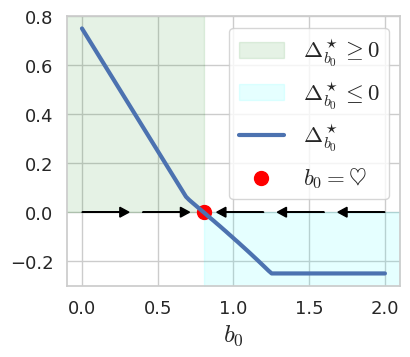

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = 'cm'
sns.set_theme(font_scale=1.5)
fig = plt.figure(figsize=(4.3, 3.5))

intersect_b0 = b0s[np.argmin(np.abs(Db0s))]

with sns.axes_style("whitegrid"):
    ax = fig.add_subplot(111)
    plt.fill_between([-1, intersect_b0], y1=0, y2=1.0, color="green", alpha=0.1, label=r"$\Delta^\star_{b_0} \geq 0$")
    plt.fill_between([intersect_b0, 3], y1=-1, y2=0, color="cyan", alpha=0.1, label=r"$\Delta^\star_{b_0} \leq 0$")

    # draw arrows
    plt.arrow(x=0, y=0, dx=0.25, dy=0, color="black", head_width=0.04, linewidth=1.0)
    plt.arrow(x=0.4, y=0, dx=0.25, dy=0, color="black", head_width=0.04, linewidth=1.0)
    plt.arrow(x=2.0, y=0, dx=-0.25, dy=0, color="black", head_width=0.04, linewidth=1.0)
    plt.arrow(x=1.6, y=0, dx=-0.25, dy=0, color="black", head_width=0.04, linewidth=1.0)
    plt.arrow(x=1.2, y=0, dx=-0.25, dy=0, color="black", head_width=0.04, linewidth=1.0)

    plt.plot(b0s, Db0s, label=r"$\Delta^\star_{b_0}$", linewidth=3)
    plt.scatter(intersect_b0, 0, color="red", s=100, label=r"$b_0=\heartsuit$")
    plt.xlabel(r"$b_0$")
    plt.xlim(-0.1, 2.1)
    plt.ylim(-0.3, 0.8)
    ax.tick_params(axis='both', which='major', labelsize=13)
    plt.legend()


plt.savefig(f"concept.pdf", bbox_inches="tight")
plt.savefig(f"concept.png", bbox_inches="tight")